# Period determination

This notebooks stars with extracted light curves for putative variable sources and performs period detection on them.

In [3]:
import numpy as np
import subprocess

from astropy.io import fits
from astropy.table import Table, Column, join
import astropy.units as u
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.timeseries import BoxLeastSquares, LombScargle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from scipy.stats import chisquare
from scipy.signal import medfilt, find_peaks

from ccdproc import CCDData, Combiner, subtract_overscan, trim_image, create_deviation

from photutils import DAOStarFinder, CircularAperture, aperture_photometry

from glob import glob

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullLocator

from brokenaxes import brokenaxes

## Reading in the data tables

In [12]:
full_crossmatch_table = Table.read("../data/NGC1866_data_tables/variable_star_parameter_table_no_period.ecsv",
                                   format="ascii.ecsv")

lc_table_v = Table.read("../data/NGC1866_data_tables/Vband_variable_lightcurve_table.ecsv",format='ascii.ecsv')
lc_table_i = Table.read("../data/NGC1866_data_tables/Iband_variable_lightcurve_table.ecsv",format='ascii.ecsv')

## The functions we need

In [6]:
def score_period(times, mags, period, hist_size=8, uselog=False, verbose=False):
    """
    Given a period score how good a fit it is.
    Uses the same algorithm as the VARTOOLS Light Curve Analysis Program.  
    """
    
    # initialize the histograms 
    histN = np.zeros(hist_size)
    histA = np.zeros(hist_size)
    histB = np.zeros(hist_size)
    histC = np.zeros(hist_size)
    histD = np.zeros(hist_size)
    histE = np.zeros(hist_size)
    
    for i in range(len(times)):
        if np.isnan(mags[i]):
            continue
            
        X = np.fmod(times[i], period) / period
        index = int(hist_size * X)
        Y = mags[i]
        
        histN[index] += 1
        histA[index] += X
        histB[index] += X * X
        histC[index] += X * Y
        histD[index] += Y
        histE[index] += Y * Y

    sums = 0
    s1 = 0
    L2 = 0
    
    for i in range(hist_size):
        N = histN[i];
        
        if (N <= 1):
            if verbose:
                print("None enough mags in bin.")
            return(100000.0) # Error score, assumed to be bigger than a valid score
        
        Y = histD[i];
        X = Y * Y / N;
        
        # Checking on the denominator
        if ((N*(np.square(histA[i]) - (histB[i]*N)))) == 0:
            #(X + X)^2 - 2*(X^2 + X^2) 
            #print(np.square(histA[i]))
            #print(histB[i]*N)
            #print(histC[i])
            #print(histD[i])
            #print(histE[i])
            #print(histN[i])
            #print()
            continue
        sums += Y
        s1 += X 
        L2 += (np.square((histC[i]*N) - (Y*histA[i])) / (N*(np.square(histA[i]) - (histB[i]*N)))) + histE[i] - X
    
    s1 -= sums * sums / len(times)
    L2 /= len(times) - hist_size
    
    if ((s1 <= 0) or (L2 <= 0)):
        if verbose:
            print("Negative s1 or L2")
        return(100000.0) # Error score, assumed to be bigger than a valid score
    elif(uselog):
        return(np.log(L2 / s1))
    else:
        return(-s1/L2)

In [9]:
def find_best_period(times, mags, errs, clip_sigma=3, peak_height=None, plots=True, outfile=None, verbose=False):
    
    # Getting rid of the nans
    times = times[~np.isnan(mags)]
    errs = errs[~np.isnan(mags)]
    mags = mags[~np.isnan(mags)]
    
    # Getting rid of outliers
    #clipped_mags = sigma_clip(mags, sigma=clip_sigma, maxiters=1)
    #times = times[~clipped_mags.mask]
    #errs = errs[~clipped_mags.mask]
    #mags = mags[~clipped_mags.mask]

    # Doing the periodogram
    lomb = LombScargle(times,mags)
    frequency = np.linspace(0,2,2680)
    frequency = frequency[1:] # need to get rid of the literal 0 point
    power = lomb.power(frequency)
    
    #frequency, power = lomb.autopower()
    
    if plots:
        fig = plt.figure(figsize=(10,8))
        ax1 = fig.add_subplot(211)
        ax1.plot(frequency, power)
        ax1.set_xlabel("frequency")
        ax1.set_ylabel("power")
        
    # Finding the peaks 
    peak_inds, _ = find_peaks(power,height=peak_height)
    peak_pds = 1/frequency[peak_inds]#.value
    
    min_score = 100000
    min_score_pd = 0
    for period in peak_pds:
        score = score_period(times, mags, period, hist_size=5, uselog=True, verbose=False)
        if score < min_score:
            min_score = score
            min_score_pd = period
            
    if verbose:
        print(f"Best score: {min_score}")
        print(f"Best period: {min_score_pd} days")
          
    if plots:
        ax2 = fig.add_subplot(212)
        ax2.errorbar(times%min_score_pd, mags, yerr=errs,
                     marker='o',linestyle='None',capsize=3)
        ax2.set_xlabel("phase (days)")
        ax2.set_ylabel("flux")
        
        if outfile:
            plt.savefig(outfile)
        
        plt.show()  
        
    return min_score_pd, min_score

### Running the period finding

#### V-band

In [14]:
full_crossmatch_table.add_column(Column(name="period_v",dtype=float,length=len(full_crossmatch_table)))
full_crossmatch_table.add_column(Column(name="score_v",dtype=float,length=len(full_crossmatch_table)))

In [15]:
for star in full_crossmatch_table:
    period,score = find_best_period(lc_table_v['date_obs'], lc_table_v[f'mag_{star["id"]}'], 
                                    lc_table_v[f'mag_err_{star["id"]}'], verbose=False, clip_sigma=2,
                                    peak_height=0.3, plots=False)
    
    star['period_v'] = period
    star['score_v'] = score

#### I-band

In [16]:
full_crossmatch_table.add_column(Column(name="period_i",dtype=float,length=len(full_crossmatch_table)))
full_crossmatch_table.add_column(Column(name="score_i",dtype=float,length=len(full_crossmatch_table)))

In [17]:
for star in full_crossmatch_table:
    period,score = find_best_period(lc_table_i['date_obs'], lc_table_i[f'mag_{star["id"]}'], 
                                    lc_table_i[f'mag_err_{star["id"]}'], verbose=False, clip_sigma=2,
                                    plots=False)
    star['period_i'] = period
    star['score_i'] = score

### Choosing whichever period had the best score as the "true" period

In [19]:
full_crossmatch_table.add_column(Column(name="period_best",dtype=float,length=len(full_crossmatch_table)))
full_crossmatch_table.add_column(Column(name="score_best",dtype=float,length=len(full_crossmatch_table)))
for star in full_crossmatch_table:
    if star["score_v"] < star["score_i"]: # V period is better
        star["period_best"] = star["period_v"]
        star["score_best"] = star["score_v"]
    else:
        star["period_best"] = star["period_i"]
        star["score_best"] = star["score_i"]

#### Saving the full crossmatch table

In [116]:
full_crossmatch_table.write("../data/NGC1866_data_tables/variable_star_parameter_table.ecsv",
                            format="ascii.ecsv", overwrite=True)

#### Making a mask to apply a score threshold

Basically by looking at the light curves by eye and knowing about how many we are looking for in the cluster, arrived at -5 as a good threshold.

In [20]:
mask = (full_crossmatch_table["score_best"] < -5)
sum(mask)

27

## Making nice plots

### Looking at some periodograms

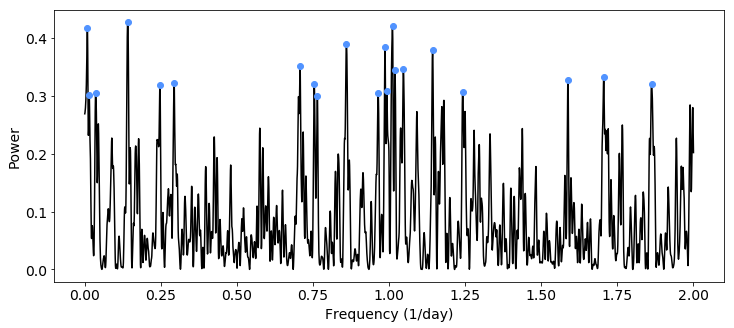

In [22]:
idx = 4
times = lc_table_v['date_obs']
mags = lc_table_v[f'mag_{idx}'] 
errs = lc_table_v[f'mag_err_{idx}']
    
# Getting rid of the nans
times = times[~np.isnan(mags)]
errs = errs[~np.isnan(mags)]
mags = mags[~np.isnan(mags)]
    

# Doing the periodogram
lomb = LombScargle(times,mags)
frequency = np.linspace(0,2,2680)
frequency = frequency[1:] # need to get rid of the literal 0 point
power = lomb.power(frequency)
    

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax1.plot(frequency, power, color='black')
ax1.set_xlabel("Frequency (1/day)", size=14)
ax1.set_ylabel("Power", size=14)
        
# Finding the peaks 
peak_inds, _ = find_peaks(power,height=0.3)

ax1.plot(frequency[peak_inds], power[peak_inds],'o', color='#5193ff')
    

#plt.savefig("../doc/plots/periodogram_aliasing.pdf")
        
plt.show()  
        

### Looking at some phased LCs

In [23]:
def phase_plot(lc_table_v, lc_table_i, star_row, save=False, outfile=None):
    
    idx = star_row["id"]
    period = star_row["period_best"]
    
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(111)
    ax1.errorbar([period/4],[0],color='white',label=f"Period: {period:.3} days")
    ax1.errorbar(lc_table_v['date_obs']%period, lc_table_v[f"mag_{idx}"], yerr=lc_table_v[f"mag_err_{idx}"],
                 marker='>',linestyle='None',capsize=3,color='#2a61bb', ms=7, label=f"V band")
    ax1.errorbar(lc_table_i['date_obs']%period, lc_table_i[f"mag_{idx}"], yerr=lc_table_i[f"mag_err_{idx}"],
                 marker='o',linestyle='None',capsize=3, mec='#d71031', color='#d71031', mfc='white', mew=1.5,
                 ms=7, label=f"I band")
    
    ax1.set_xlabel("Phase (days)", fontsize=14)
    ax1.set_ylabel("Relative Flux (phot/sec)", fontsize=14)
    ax1.legend(fontsize=12)

    plt.tight_layout()
        
    if save:
        if not outfile:
            outfile = f"../doc/plots/phased_lc_{idx}.pdf"
        plt.savefig(outfile)
        
    plt.show()  
    

In [24]:
passing_variable_table = full_crossmatch_table[mask]

#### A really nice Cepheid LC

 id    period_best        score_best    
--- ----------------- ------------------
 13 3.443444730077121 -5.412104962432396


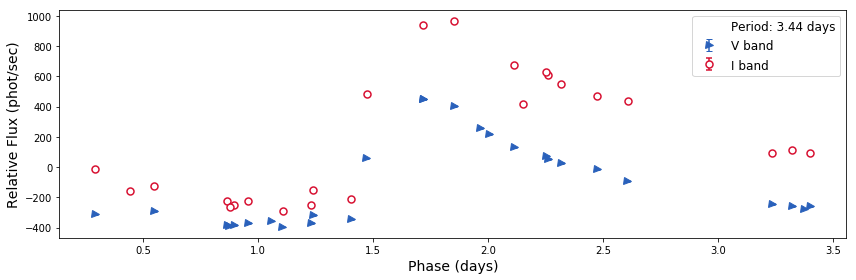

In [25]:
print(passing_variable_table["id", "period_best","score_best"][6])
phase_plot(lc_table_v, lc_table_i,passing_variable_table[6],save=False)

#### The one with the 50 day period

 id    period_best        score_best    
--- ----------------- ------------------
  8 51.51923076923077 -5.710232706459219


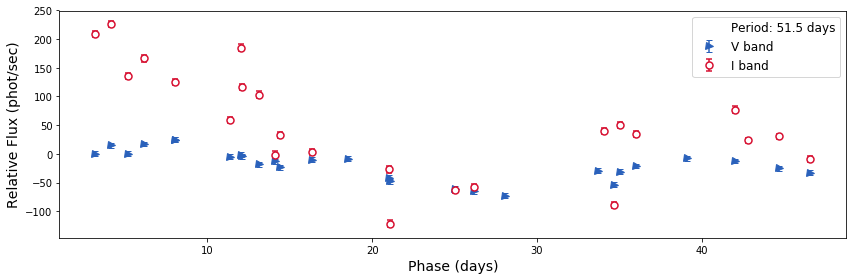

In [26]:
print(passing_variable_table["id", "period_best","score_best"][3])
phase_plot(lc_table_v, lc_table_i,passing_variable_table[3],save=False)

#### An example of a bad one

 id    period_best          score_best    
--- ------------------ -------------------
  6 3.2045454545454546 -5.0092684565705605


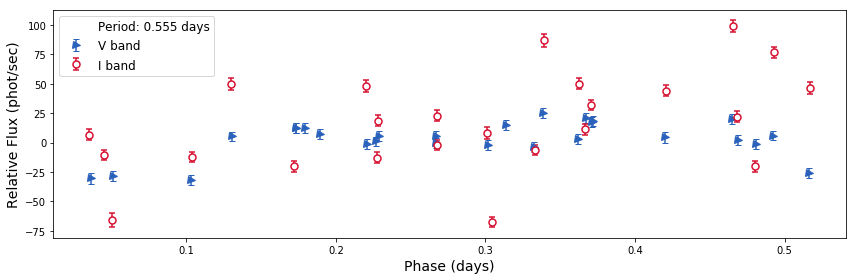

In [28]:
print(passing_variable_table["id", "period_best","score_best"][1])
phase_plot(lc_table_v, lc_table_i,full_crossmatch_table[~mask][1],save=False)

#### The one in the OGLE database that didn't pass my threshold

 id    period_best         score_best    
--- ------------------ ------------------
 26 2.8930885529157666 -4.585780801422439


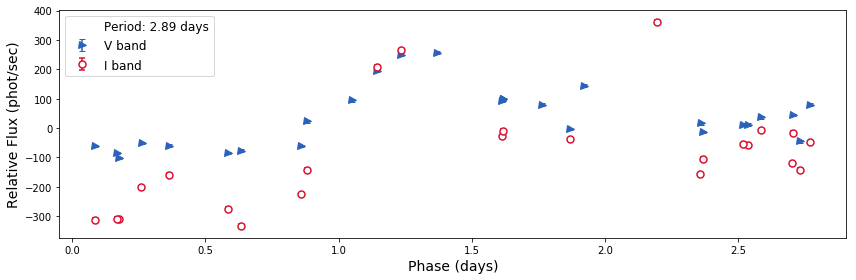

In [29]:
print(full_crossmatch_table["id", "period_best","score_best"][25])
phase_plot(lc_table_v, lc_table_i,full_crossmatch_table[25],save=False)

## Histogramming the periods

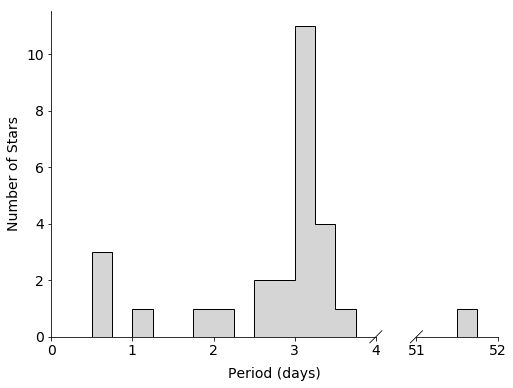

In [30]:
ig = plt.figure(figsize=(8,6))
fig.set_facecolor('w')
 
bins = np.linspace(0,52,52*4+1) 
bax = brokenaxes(xlims=((0, 4), (51, 52)))
bax.hist(passing_variable_table['period_best'], bins=bins, histtype='stepfilled', edgecolor='black', color='#d5d5d5')

bax.tick_params(axis='both', which='major', labelsize=14)

bax.set_xlabel("Period (days)", size=14)
bax.set_ylabel("Number of Stars", size=14)

fig.savefig("../doc/plots/period_histogram.pdf")

plt.show()